# Walk-through Exercises

### Required imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

### Methods to be used later

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "recap"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9. 
#### We would first need to load the data and split it into test and training set.

In [3]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [4]:
X_train, X_test, y_train, y_test = \
train_test_split(
    X_digits,
    y_digits,
    random_state=42
)

Now let's fit a Logistic Regression model:

In [5]:
log_reg = \
LogisticRegression(
    multi_class="ovr",
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

Now evaluate the Logistic Regression over the test set. You should get about 0.96 accuracy.

In [6]:
log_reg.score(X_test, y_test)

0.9688888888888889

That accuracy will be our baseline to check the benefits of using clustering as a preprocessing step.

Go ahead and **create a pipepline** that will:

We will create a pipeline that will first cluster the training set into 50 

1.   Cluster the training set into 50 clusters. Why 50? Well, we know we have 10 classes so it can be tempting to set $k=10$ but there are many digits that have different handwritting and we need to account for that. Running the K-Means will replace the images with their distances to those $k$ clusters.
2.   Apply Logistic Regression model. Use the following setup:
    * `multi_class="ovr"`
    * `solver="lbfgs"`
    * `max_iter=5000`
    * `random_state=42`
3. Fit the pipeline to `X_train` and `y_train`


In [7]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50,
                      random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr",
                                   solver="lbfgs",
                                   max_iter=5000,
                                   random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

Now print the pipeline score. Which accuracy did you get? You should get about 0.97

In [8]:
pipeline.score(X_test, y_test)

0.9777777777777777

Now calculate the reduction of the error rate, you can do this by...

$1 - (1 - Pipeline Score) / (1 - Original Score)$

You should get about a 28% reduction of error rate. That means going from 3% error to 2% error.

In [9]:
1 - (1 - 0.98) / (1 - 0.968888)

0.3571612239650296

Thats a very decent error rate reduction, just by passing a dataset to the classifier which has been clustered before. But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. 

Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's **no need to perform silhouette analysis** or **minimize the inertia**, the best value of $k$ is simply the one that results in the best classification performance during cross validation.

How could we do that? You are right, by passing the pipeline through `GridSearchCV` (remember to call `GridSearchCV` and fit it to `X_train` and `y_train`). Also remember that we need to look for the number of clusters, so pass the `param_grid` values with a range of clusters from at least 2 to for instance 100.

Hint, refer to the `n_clusters` parameter as `kmeans__n_clusters`. Beware!!!! This will take quite a bit, so run it and go for a coffee. Try it first in not so many clusters, so you can check that your code works. The life of a data scientist allows for many coffee breaks if automatization is done correctly :)

In [10]:
# Doing 20 here now just to go faster in class
param_grid = dict(kmeans__n_clusters=range(2, 100))

grid_clf = GridSearchCV(pipeline,
                        param_grid,
                        cv=3,
                        verbose=2,
                        n_jobs=-1)

grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             n_jobs=-1, param_grid={'kmeans__n_clusters': range(2, 100)},
             verbose=2)

Print the best parameters that we have defined (`kmeans__n_clusters`)

In [11]:
# We will get bad scores here because we purposedly set the maximum number of clusters to 20
grid_clf.best_params_

{'kmeans__n_clusters': 95}

Print the resulting score of the GridSearchCV, you should get about 98 to 99% accuracy. And you should get that you got your best values with $k=99$

In [12]:
# With 99 clusters we will get about 99%, but we only used  k=19
grid_clf.score(X_test, y_test)

0.9777777777777777

### Clustering for Semi-supervised Learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances. We can reduced the MNIST dataset loaded previously to just the last 50 instances.

In [13]:
n_labeled = 50

In [14]:
log_reg = LogisticRegression(multi_class="ovr",
                             solver="lbfgs",
                             random_state=42
                            )

log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the **representative** images:

In [15]:
k = 50

In [16]:
kmeans = KMeans(n_clusters=k,
                random_state=43
               )
X_digits_dist = kmeans.fit_transform(X_train)

# Using argmin to calculate the images that are closer to each centroid
representative_digit_idx = np.argmin(X_digits_dist,
                                     axis=0)

# Creating a representative digits matrix by indexing the indexes of those representative images
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

Saving figure representative_images_diagram


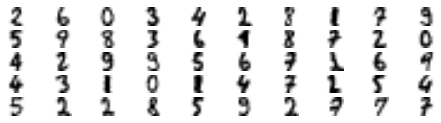

In [17]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [18]:
"""
# You will need to label here whatever appeared 
in your most representative images according to your random_state
"""
y_representative_digits = np.array([
    2, 6, 0, 3, 4, 2, 8, 1, 7, 9,
    5, 9, 8, 3, 6, 1, 8, 7, 2, 0,
    4, 2, 9, 9, 5, 6, 7, 1, 6, 9,
    4, 3, 1, 0, 8, 4, 7, 2, 5, 4,
    5, 2, 2, 8, 5, 9, 2, 7, 7, 7])

In [19]:
# Above in the last row in position 5 is not an "8" is an "1"
#y_train[representative_digit_idx]

Now we have a dataset of the most representative instances labeled. Unfortunately we only have 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [20]:
log_reg = LogisticRegression(
    multi_class="ovr",
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

log_reg.fit(X_representative_digits,
            y_representative_digits)
log_reg.score(X_test, y_test)

0.9244444444444444

Wow! We jumped from 83.3% accuracy to 92.2%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

So this is a very good technique to first take those most representative instances and label them, instead of labelling randomly.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [21]:
# Create an empty matrix with the length of X_train
y_train_propagated = np.empty(len(X_train),
                              dtype=np.int32)

"""
Propagate the cluster instances into that matrix by propagating the representative
digit value to the full cluster that has that value
"""
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [22]:
log_reg = LogisticRegression(multi_class="ovr",
                             solver="lbfgs",
                             max_iter=5000,
                             random_state=42)

log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [23]:
log_reg.score(X_test, y_test)

0.9266666666666666

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. This might lead to a lot of problems, such as overfitting. Let's only propagate the labels to the 30th percentile closest to the centroid:

In [24]:
percentile_closest = 30

# Create an empty matrix with the length of X_train
X_cluster_dist = X_digits_dist[np.arange(len(X_train)),
                               kmeans.labels_]

for i in range(k):
    # Get the clusters that has the i value
    in_cluster = (kmeans.labels_ == i)

    # Index the newly created X_cluster_dist with in_cluster
    cluster_dist = X_cluster_dist[in_cluster]

    # Set up the percentile distance by using np.percentile
    cutoff_distance = np.percentile(cluster_dist,
                                    percentile_closest)

    # Set a value to be above the cluster distance
    above_cutoff = (X_cluster_dist > cutoff_distance)

    # Set X_cluster_dist values to -1 when those are above cutoff distance
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [25]:
# Get the real propagated values (not -1)
partially_propagated = (X_cluster_dist != -1)

# Index those values to X_train
X_train_partially_propagated = X_train[partially_propagated]

# Index those values to y_train
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [26]:
log_reg = LogisticRegression(multi_class="ovr",
                             solver="lbfgs",
                             max_iter=5000,
                             random_state=42)

log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [27]:
log_reg.score(X_test, y_test)

0.92

Nice! With just 50 labeled instances (just 5 examples per class on average!), we got 94% performance, which is pretty close to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%). We got a bit lower performance but results should be more stable.

This is because the propagated labels are actually pretty good: their accuracy is very close to 99%:

In [28]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9734939759036144